# Data Preparation for LTI State Space Model Tube MPC using pretrained TiDE model -- with Anciliary Controller (Tube only)

Generate data for response mean and tube quantile

In [1]:
# Import all the packages we need
import numpy as np
import pandas as pd
from typing import Optional, Tuple

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm

# from pytorch_forecasting.metrics.quantile import QuantileLoss

from scipy.optimize import minimize, Bounds

# For TiDE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

from sklearn.preprocessing import StandardScaler
from torch.nn import functional as F


import warnings
import pickle

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

# import functions
from TiDE import TideModule, quantile_loss, TiDE_forward
from sys_model import nominal_model, nominal_model_recur, system_model
from RobustMPC import RMPC_iteration

cuda is available


## 1. Set the MPC horizons

In [2]:
# ===== Additional MPC parameters ===================
M = 10 # Control Horizon
P = 10

include_u_hist = False

## 2. Process Model 

In [3]:
# # Window = 2 =================================================
# # Open the pickle file
# with open('nominal_params_w2.pkl', 'rb') as file:
#     # 2. Load the data from the pickle file
#     nominal_params = pickle.load(file)
# # Load nominal TiDE model
# nominal_TiDE = nominal_params['model'].to("cpu")
# nominal_TiDE.load_state_dict(torch.load('nominal_params_w2.pth'))
# nominal_TiDE.eval()
# window = 2

# # # Window = 1 =================================================
# # Open the pickle file
# with open('nominal_params_w1_more.pkl', 'rb') as file:
#     # 2. Load the data from the pickle file
#     nominal_params = pickle.load(file)
# # Load nominal TiDE model
# nominal_TiDE = nominal_params['model'].to("cpu")
# nominal_TiDE.load_state_dict(torch.load('nominal_params_w1_more.pth'))
# nominal_TiDE.eval()
# window = 1

# Window = 1 =================================================
# Open the pickle file
with open('nominal_params_w10_mid_noise_stable.pkl', 'rb') as file:
    # 2. Load the data from the pickle file
    nominal_params = pickle.load(file)
# Load nominal TiDE model
nominal_TiDE = nominal_params['model'].to("cpu")
nominal_TiDE.load_state_dict(torch.load('nominal_params_w10_mid_noise_stable.pth'))
nominal_TiDE.eval()
window = 10

# # Window = 1, large variation, more data =================================================
# # Open the pickle file
# with open('nominal_params_w1_100k.pkl', 'rb') as file:
#     # 2. Load the data from the pickle file
#     nominal_params = pickle.load(file)
# # Load nominal TiDE model
# nominal_TiDE = nominal_params['model'].to("cpu")
# nominal_TiDE.load_state_dict(torch.load('nominal_params_w1_100k.pth'))
# nominal_TiDE.eval()
# window = 1

# # Window = 10, noisy ============================================
# # Open the pickle file
# with open('nominal_params_w10_noisy.pkl', 'rb') as file:
#     # 2. Load the data from the pickle file
#     nominal_params = pickle.load(file)
# # Load nominal TiDE model
# nominal_TiDE = nominal_params['model'].to("cpu")
# nominal_TiDE.load_state_dict(torch.load('nominal_params_w10_noisy.pth'))
# nominal_TiDE.eval()
# include_u_hist = True
# window = 10

# Window = 10, noisy ============================================
# # Open the pickle file
# with open('nominal_params_w10_w0.pkl', 'rb') as file:
#     # 2. Load the data from the pickle file
#     nominal_params = pickle.load(file)
# # Load nominal TiDE model
# nominal_TiDE = nominal_params['model'].to("cpu")
# nominal_TiDE.load_state_dict(torch.load('nominal_params_w10_w0.pth'))
# nominal_TiDE.eval()
# include_u_hist = True
# window = 10

# # Window = 10 =====================================================
# # Open the pickle file
# with open('nominal_params_w10.pkl', 'rb') as file:
#     # 2. Load the data from the pickle file
#     nominal_params = pickle.load(file)
# # Load nominal TiDE model
# nominal_TiDE = nominal_params['model'].to("cpu")
# nominal_TiDE.load_state_dict(torch.load('nominal_params_w10.pth'))
# nominal_TiDE.eval()
# window = 10

# # Window = 10, MSELoss ==========================================
# # Open the pickle file
# with open('nominal_params_mseloss_w10.pkl', 'rb') as file:
#     # 2. Load the data from the pickle file
#     nominal_params = pickle.load(file)
# # Load nominal TiDE model
# nominal_TiDE = nominal_params['model'].to("cpu")
# nominal_TiDE.load_state_dict(torch.load('nominal_params_mseloss_w10.pth'))
# nominal_TiDE.eval()
# window = 10

## 3. MPC function with TiDE

In [4]:
def MPC_obj_TiDE(u_hat:np.array, # future u values within the control horizon, length = M; this should be the warm start version
                u_past:np.array, # past u
                x_past: np.array, # past state of x, size (N,window)
                SP_hat:np.array, # Reference trajectory, length = P
                P, # Predictive Horizon
                TiDE # TiDE model that we're using
):
    
    # convert u_hat into tensor and set u_hat as variable
    u_hat = torch.tensor(u_hat.reshape(-1,1), requires_grad=True, dtype=torch.float32)
    u_hat_in = u_hat.unsqueeze(0)
    
    # knit past and future covariate into the input format for TiDE
    past_cov = torch.tensor(np.concatenate((x_past,u_past), axis = 0),dtype=torch.float32).transpose(1,0).unsqueeze(0)
    # TiDE prediction
    x_hat = TiDE([past_cov,u_hat_in,None])
    
    global x_hat_global
    x_hat_global = x_hat

    # compute objective value
    x_hat = x_hat[0,:,0,1]
    u_hat_temp = u_hat_in[0,:,0].reshape(-1,1) 

    u = u_hat_temp[0].reshape(-1,1)
    u_hat0 = torch.concatenate((u,u_hat_temp)) # append the computed u with the history u
    
    Obj = 1 * torch.sum((x_hat-torch.tensor(SP_hat,dtype=torch.float32))**2) + 1*torch.sum((u_hat0[1:]-u_hat0[0:-1])**2)
    Obj.backward()

    return Obj.item(), u_hat.grad.numpy().reshape(-1) 


## 4. MPC in a single iteration

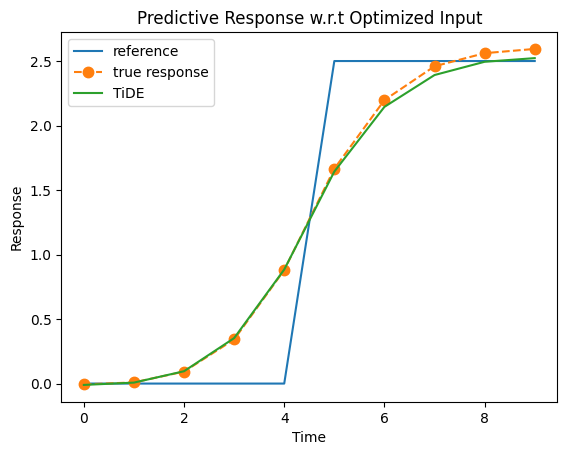

In [5]:
#  === Initial Conditions: Values at time = k ==================
u_hat = np.zeros((P))
x_past = np.zeros((2,window))
u_past = np.zeros((1,window))
x_current = np.zeros((2,1))
x_sys_current = x_current
x_hat_current = x_current
K_ac = np.array([[-0.2068,-0.6756]])

SP_hat = np.array([0,0,0,0,0,1,1,1,1,1])*2.5

MPC = RMPC_iteration(u_hat=u_hat,
                     x_past=x_past,
                     u_past=u_past,
                     window=window,
                     P=P,
                     x_current=x_current,
                     K_ac=K_ac,
                     sys_params=nominal_params,
                     optim_obj=MPC_obj_TiDE,
                     include_u_hist=False,
                     NN_model = nominal_TiDE,
                     NN_forward=TiDE_forward
                     )
MPC.Plot_one_step(SP_hat)

In [6]:
MPC.latest_solution

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.18384498357772827
       x: [-2.534e-03  4.839e-03  3.523e-02  1.183e-01  2.854e-01
            4.970e-01  5.635e-01  5.776e-01  5.764e-01  5.746e-01]
     nit: 14
     jac: [-1.696e-04 -1.966e-04  3.282e-05  6.244e-05 -1.738e-03
            6.489e-04 -1.631e-04 -7.191e-04  3.031e-04 -8.089e-05]
    nfev: 24
    njev: 14

## 5-1. MPC on the fly

#### Load trajectory

In [7]:
# path = ''
# data = pd.read_pickle(path + 'open_loop_data_SISO.pkl')

# data["y"][1:] = data["y"][0:-1]
# Ref_traj = data["y"].values*3
# Ref_traj = np.concatenate((np.zeros((20)),Ref_traj))*0.5

#### Run MPC in noiseless environment

In [8]:
# #  === Initial Conditions: Values at time = k ==================
# u_hat = np.zeros((P))
# x_past = np.zeros((2,window))
# u_past = np.zeros((1,window))
# x_current = np.zeros((2,1))
# x_sys_current = x_current
# x_hat_current = x_current

# K_ac = np.array([[-0.2068,-0.6756]])

# MPC = RMPC_iteration(u_hat=u_hat,
#                      x_past=x_past,
#                      u_past=u_past,
#                      window=window,
#                      P=P,
#                      x_current=x_current,
#                      K_ac=K_ac,
#                      sys_params=nominal_params,
#                      optim_obj=MPC_obj_TiDE,
#                      include_u_hist=False,
#                      NN_model = nominal_TiDE,
#                      NN_forward=TiDE_forward
#                      )

# # Run MPC

# n_steps = 200

# for i in range(n_steps):
#     SP_hat = Ref_traj[i:i+P]
#     MPC.run_one_step(SP_hat=SP_hat,sys_noise=False,RMPC=False)

# MPC.Plot_ref_only(Ref_traj,n_steps)

# 5-2 MPC on the fly with Anciliary control in noisy environment

In [9]:
# #  === Initial Conditions: Values at time = k ==================
# u_hat = np.zeros((P))
# x_past = np.zeros((2,window))
# u_past = np.zeros((1,window))
# x_current = np.zeros((2,1))
# x_sys_current = x_current
# x_hat_current = x_current

# K_ac = np.array([[-0.2068,-0.6756]])*0.3
# #K_ac = np.array([[-0.6167, -1.2703]])

# MPC = RMPC_iteration(u_hat=u_hat,
#                      x_past=x_past,
#                      u_past=u_past,
#                      window=window,
#                      P=P,
#                      x_current=x_current,
#                      K_ac=K_ac,
#                      sys_params=nominal_params,
#                      optim_obj=MPC_obj_TiDE,
#                      include_u_hist=False,
#                      NN_model = nominal_TiDE,
#                      NN_forward=TiDE_forward,
#                      error_past=None
#                      )



# # Run MPC

# n_steps = 200

# for i in range(n_steps):
#     SP_hat = Ref_traj[i:i+P]
#     MPC.run_one_step(SP_hat=SP_hat)

# # Plots    
# MPC.Plot_standard(Ref_traj,n_steps,plot_traj_steps=n_steps)



In [10]:
# MPC.Plot_input_output()

#### Make Animation

In [11]:
# MPC_iters = n_steps

# # Set up the figure
# fig, ax = plt.subplots(figsize=(9, 4), dpi=100)
# ax.set_xlabel("Time",fontsize=14)
# ax.set_ylabel("x1",fontsize=14)
# plt.xlim(-1,MPC_iters + P)
# plt.ylim(-2,7)

# Ref_traj_plot, = ax.plot(Ref_traj[:n_steps], linewidth=3,label="Reference")
# real_output_plot, = ax.plot([],[], label="Output")
# point_current, = ax.plot([], [], ".", markersize=20, label="Current")
# line_pred, = ax.plot([], [], "-", linewidth=3.5, color="red", label="Prediction")
# line_true, = ax.plot([], [], "-", linewidth=3.5, color="green", label="True")
# ax.legend(loc='lower center', ncol=4)


# # Function to update the plot in each iteration
# def update(iter):
#     real_output_plot.set_data(np.linspace(0, len(MPC.real_output[0,:iter])-1, len(MPC.real_output[0,:iter])), MPC.real_output[0,:iter])
#     point_current.set_data(iter, MPC.real_output[0,iter])
#     line_pred.set_data(np.linspace(iter,iter+P+1,P+1),np.concatenate((MPC.real_output[0,iter].reshape(-1,1),MPC.x_hat_horizon_save[iter,:].reshape(-1,1)),axis=0))
#     line_true.set_data(np.linspace(iter,iter+P+1,P+1),np.concatenate((MPC.real_output[0,iter].reshape(-1,1),MPC.true_pred_output_x1_save[iter,:].reshape(-1,1)),axis=0))
#     return real_output_plot, point_current, line_pred, line_true
# # Create animation
# animation = FuncAnimation(fig, update, frames=MPC_iters,  blit=True)

# # # Show the animation
# HTML(animation.to_jshtml())
# plt.rcParams["animation.html"] = "jshtml"
# #animation.save('test.gif', writer='imagemagick', fps=5)
# animation

# Data Generation and Preprocessing

#### Crafting trajectory
The puropose of crafting a trajectory is to 
1. do replicate simulations
2. increase the coverage of the state space

In [12]:
# # craft a trajectory -- Park's 
# data["y"][1:] = data["y"][0:-1]
# # First piece
# Ref_traj_1 = data["y"].values*3
# Ref_traj = np.concatenate((np.zeros((20)),Ref_traj_1))
# # Second piece
# Ref_traj_2 = data["y"].values*-1
# Ref_traj = np.concatenate((Ref_traj,Ref_traj_2))
# # Third piece
# Ref_traj_3 = data["y"].values*2
# Ref_traj = np.concatenate((Ref_traj,Ref_traj_3))
# # Forth piece
# Ref_traj_4 = data["y"].values*1
# Ref_traj = np.concatenate((Ref_traj,Ref_traj_4))
# # Fifth piece
# Ref_traj_5 = data["y"].values*3 - 1.5
# Ref_traj = np.concatenate((Ref_traj,Ref_traj_5))
# # Sixth piece
# Ref_traj_6 = data["y"].values*-2 
# Ref_traj = np.concatenate((Ref_traj,Ref_traj_6))
# # 7th piece
# Ref_traj_7 = data["y"].values - 1.5
# Ref_traj = np.concatenate((Ref_traj,Ref_traj_7))

# # duplicate the whole trajectory
# Ref_traj = np.concatenate((Ref_traj,Ref_traj*-1))
path = ''
data = pd.read_pickle(path + 'open_loop_data_SISO.pkl')

data["y"][1:] = data["y"][0:-1]

# Random number
repeat_count = 5
rand_num = np.repeat(np.random.uniform(-2.5,2.5, size=2000),20)
Ref_traj = np.tile(rand_num,2)
rand_num = np.repeat(np.random.uniform(-1.5,1.5, size=500),20)
Ref_traj = np.concatenate((Ref_traj, rand_num))

Ref_traj = np.concatenate((np.zeros(25),np.concatenate((Ref_traj, data["y"].values*2 - 1.5))))

Ref_traj = np.tile(Ref_traj,repeat_count)
print(f"Trajectory length = {Ref_traj.shape}")
n_steps = Ref_traj.shape[0] - 20

Trajectory length = (458125,)


#### Run RMPC simulation

In [13]:

#  === Initial Conditions: Values at time = k ==================
u_hat = np.zeros((P))
x_past = np.zeros((2,window))
u_past = np.zeros((1,window))
x_current = np.zeros((2,1))
x_sys_current = x_current
x_hat_current = x_current

K_ac = np.array([[-0.2068,-0.6756]])*0.3

MPC = RMPC_iteration(u_hat=u_hat,
                     x_past=x_past,
                     u_past=u_past,
                     window=window,
                     P=P,
                     x_current=x_current,
                     K_ac=K_ac,
                     sys_params=nominal_params,
                     optim_obj=MPC_obj_TiDE,
                     include_u_hist=False,
                     NN_model = nominal_TiDE,
                     NN_forward=TiDE_forward
                     )

# Run MPC



In [41]:



for i in tqdm(range(n_steps)):
    SP_hat = Ref_traj[i:i+P]
    MPC.run_one_step(SP_hat=SP_hat)









100%|██████████| 458105/458105 [5:23:04<00:00, 23.63it/s]  


#### Save tube simulation data

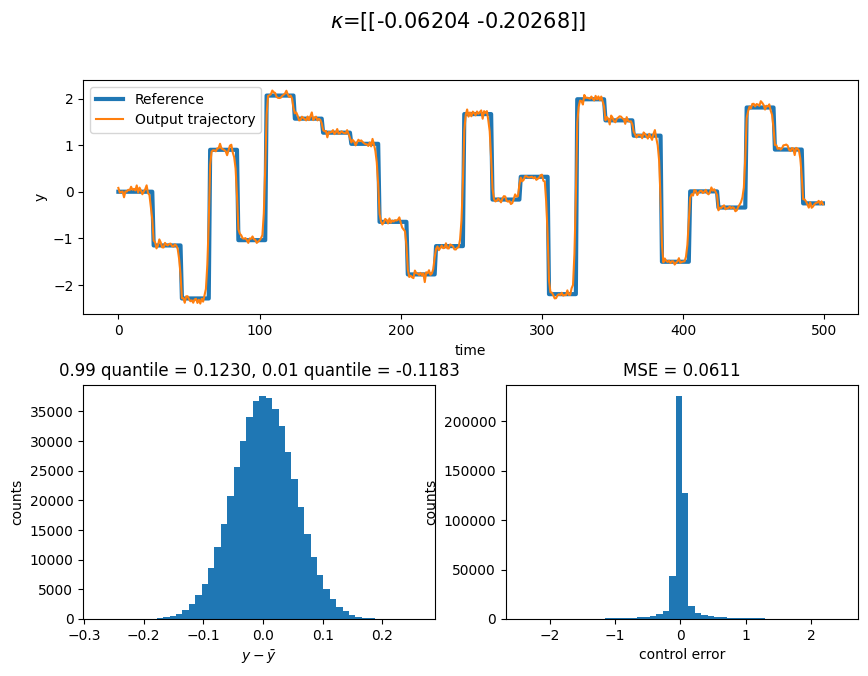

In [43]:
# Plots    
MPC.Plot_standard(Ref_traj,n_steps, plot_traj_steps = 500)

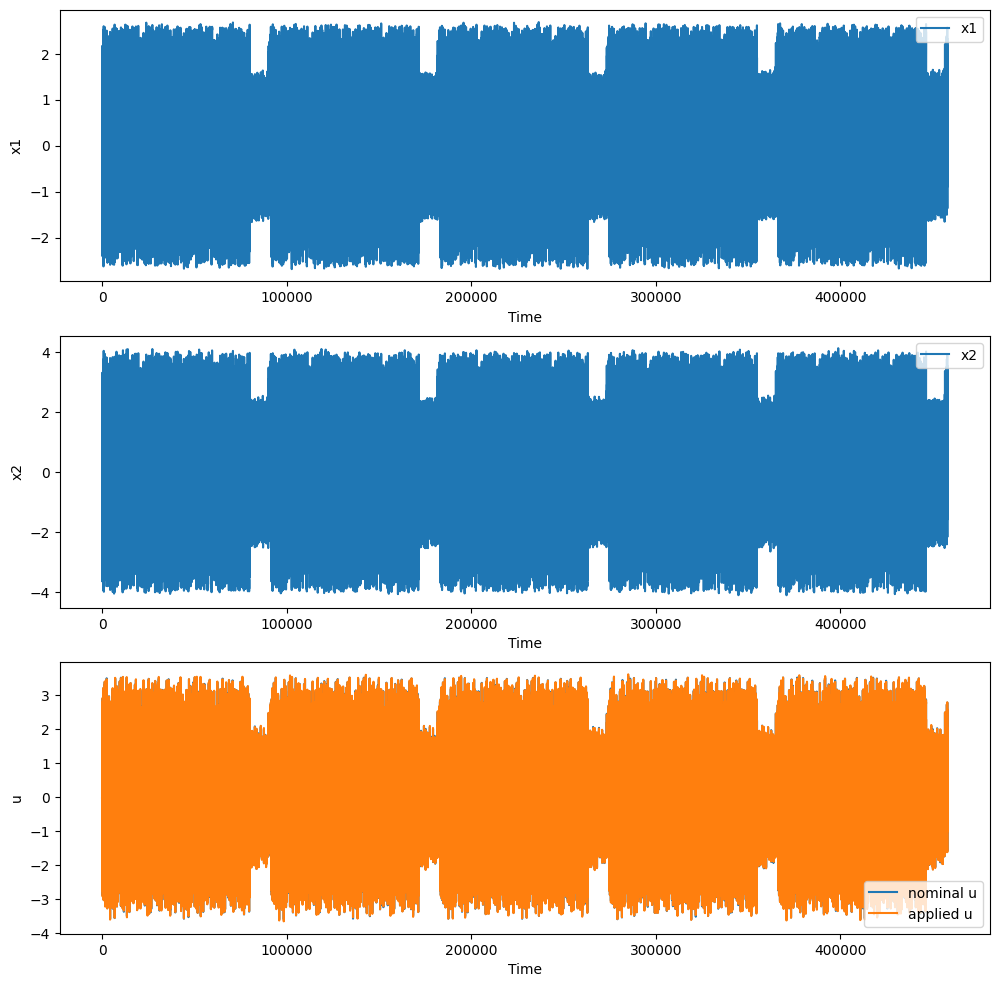

In [44]:
MPC.Plot_input_output()

In [45]:
# MPC_run_data_save = dict()
# MPC_run_data_save["real_output"] = MPC.real_output
# MPC_run_data_save["u_applied"] = MPC.u_applied_save
# MPC_run_data_save["error_save"] = MPC.e_save

# with open('MPC_tube_sim_data_save_smaller_range.pkl', 'wb') as file:
#     pickle.dump(MPC_run_data_save, file)
    


In [14]:
with open('MPC_tube_sim_data_save_smaller_range.pkl', 'rb') as file:
    MPC_run_data_save = pickle.load(file)
    
MPC.real_output = MPC_run_data_save["real_output"]
MPC.u_applied_save = MPC_run_data_save["u_applied"]
n_steps = MPC.real_output.shape[1] - window - P

#### Normalization and Slicing

In [22]:
# window size and predictive horizon
window = 10
P = 10

x_min = np.min(MPC.real_output,axis=1).reshape(2,1)
x_max = np.max(MPC.real_output,axis=1).reshape(2,1)
u_min = np.min(MPC.u_applied_save,axis=1).reshape(-1,1)
u_max = np.max(MPC.u_applied_save,axis=1).reshape(-1,1)

# Function to normalize an array to the scale of -1 and 1
def normalize_array(arr):
    if arr.shape[0]>1:
        min_val = np.min(arr,axis=1).reshape(-1,1)
        max_val = np.max(arr, axis = 1).reshape(-1,1)
        diff = (max_val - min_val).reshape(-1,1)
        print(diff)
        normalized_arr = -1 + 2 * ((arr - min_val) / diff)
    else:
        min_val = np.min(arr)
        max_val = np.max(arr)
        diff = (max_val - min_val)
        normalized_arr = -1 + 2 * ((arr - min_val) / diff)
    return normalized_arr


# Fit MinMax Scaler
X = MPC.real_output
X_scaled = normalize_array(X)


#U_scaled = scaler_u.fit_transform((MPC.u_applied_save)) # this scaler is wrong
U = MPC.u_applied_save.transpose(1,0)
U_scaled = normalize_array(U).transpose(1,0)
U_dim = U_scaled.shape[1]

# Training ratio
training_ratio = 0.8
cut_index = int(n_steps*training_ratio)

Xs_train = X_scaled[:,0:cut_index]
Us_train = U_scaled[0:cut_index]

Xs_val = X_scaled[:,cut_index:]
Us_val = U_scaled[cut_index:]

# Training set
num_train_samples = Xs_train.shape[1] - window - P
U_train = np.zeros((num_train_samples, window + P, U_dim))
X_train_past = np.zeros((num_train_samples, window, 2))
X_train = np.zeros((num_train_samples, P, 2))

for i in range(num_train_samples):
    U_train[i] = Us_train[i:i + window + P].reshape(window + P, U_dim)
    X_train_past[i] = Xs_train[:, i:i + window].transpose()
    X_train[i] = Xs_train[:, i + window:i + window + P].transpose()

# Convert it into the correct piece/shape and convert it into torch and device
Input_past = torch.tensor(np.concatenate((X_train_past, U_train[:, :window, :]), axis=2)).type(torch.float32).to(device)
Input_future_covariates = torch.tensor(U_train[:, -P:, :]).type(torch.float32).to(device)
Input_target = torch.tensor(X_train).type(torch.float32).to(device)

# Validation set
num_val_samples = Xs_val.shape[1] - window - P
U_val = np.zeros((num_val_samples, window + P, U_dim))
X_val_past = np.zeros((num_val_samples, window, 2))
X_val = np.zeros((num_val_samples, P, 2))

for i in range(num_val_samples):
    U_val[i] = Us_val[i:i + window + P].reshape(window + P, U_dim)
    X_val_past[i] = Xs_val[:, i:i + window].transpose()
    X_val[i] = Xs_val[:, i + window:i + window + P].transpose()

Val_past = torch.tensor(np.concatenate((X_val_past, U_val[:, :window, :]), axis=2)).type(torch.float32).to(device)
Val_future_covariates = torch.tensor(U_val[:, -P:, :]).type(torch.float32).to(device)
Val_target = torch.tensor(X_val).type(torch.float32).to(device)

Val_in = [Val_past, Val_future_covariates, None]

print(f"Input_past size = {Input_past.size()}, Input_future_cov size = {Input_future_covariates.size()}, Input_target size = {Input_target.size()}")
print(f"Val_past size = {Val_past.size()}, Val_future_cov size = {Val_future_covariates.size()}, Val_target size = {Val_target.size()}")

[[5.37571416]
 [8.22333796]]
Input_past size = torch.Size([366448, 10, 3]), Input_future_cov size = torch.Size([366448, 10, 1]), Input_target size = torch.Size([366448, 10, 2])
Val_past size = torch.Size([91617, 10, 3]), Val_future_cov size = torch.Size([91617, 10, 1]), Val_target size = torch.Size([91617, 10, 2])


#### Build TiDE model

In [23]:
output_dim = 2
future_cov_dim = 1

Controlled_quantile = TideModule(
        input_dim = output_dim + future_cov_dim,
        output_dim = output_dim,
        future_cov_dim = future_cov_dim,
        static_cov_dim = 0,
        input_chunck_length = window,
        output_chunk_length = P,
        nr_params = 3,
        num_encoder_layers = 1,
        num_decoder_layers = 1,
        decoder_output_dim = 16,
        hidden_size = 128,
        temporal_decoder_hidden = 32,
        temporal_width_past = 4,
        temporal_width_future = 4,
        use_layer_norm = True,
        dropout = 0.2,
    ).to(device)

# Define optimizer, loss function, and metrics
#optimizer = torch.optim.Adam(Controlled_quantile.parameters(),lr=0.001,weight_decay=0.002)
optimizer = torch.optim.SGD(Controlled_quantile.parameters(),lr=0.001,weight_decay=0.002)
criterion = quantile_loss
#criterion = torch.nn.MSELoss()
num_epoch = 1500
# # # Add a LR decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

#num_epoch = 200
# # Add a LR decay
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)



TiDE_params = dict()
TiDE_params["model"] = Controlled_quantile
TiDE_params["x_min"] = torch.tensor(x_min,dtype=torch.float32)
TiDE_params["x_max"] = torch.tensor(x_max,dtype=torch.float32)
TiDE_params["u_min"] = torch.tensor(u_min,dtype=torch.float32)
TiDE_params["u_max"] = torch.tensor(u_max,dtype=torch.float32)
TiDE_params["window"] = window
TiDE_params["P"] = P

path = ''
dump(TiDE_params, open(path + 'MPC_controlled_quantile_params_w10_larger_lr.pkl', 'wb'))

#### Train TiDE model

In [24]:
# Create DataLoader for training data
train_dataset = TensorDataset(Input_past, Input_future_covariates,Input_target)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

best_model = None
best_validation_loss = float("inf")

save_train_loss = np.zeros(num_epoch)
save_val_loss = np.zeros(num_epoch)

epoch = 0
loss=0
val_loss=0

with tqdm(total=num_epoch, desc=f"Epoch = {epoch}, Train loss = {loss:.4f}, Val loss = {val_loss:.4f}") as pbar:
    for epoch in range(num_epoch):
        for input_past, input_future, input_target in train_loader:
            x_in = [input_past, input_future, None]

            Controlled_quantile.train()
            optimizer.zero_grad()
            output = Controlled_quantile(x_in)
            quantiles = [0.05, 0.5, 0.95]
            loss = criterion(output,input_target,quantiles)
            #loss = criterion(output,input_target)
            loss.backward()
            optimizer.step()

        Controlled_quantile.eval()
        val_out = Controlled_quantile(Val_in)
        val_loss = criterion(val_out,Val_target,quantiles)
        #val_loss = criterion(val_out,Val_target)

        if val_loss < best_validation_loss:
            best_val_loss = val_loss
            best_model = Controlled_quantile.state_dict()
        
        save_train_loss[epoch] = loss
        save_val_loss[epoch] = val_loss

        # if epoch % 1000 == 0:
        #     print(f"Epoch = {epoch}, Train loss = {loss:.4f}, Val loss = {val_loss:.4f}")

        scheduler.step()
        
        pbar.set_description(f"Epoch = {epoch}, Train loss = {loss:.4f}, Val loss = {val_loss:.4f}")
        pbar.update(1)
# Save the model (state_dict) after training
torch.save(best_model, 'MPC_controlled_quantile_TiDE_w10_larger_lr_less_epoch.pth')

Epoch = 1499, Train loss = 0.0205, Val loss = 0.0201: 100%|██████████| 1500/1500 [4:40:35<00:00, 11.22s/it]  


In [25]:
# Save the model (state_dict) after training
torch.save(best_model, 'MPC_controlled_quantile_TiDE_w10_larger_lr_less_epoch.pth')

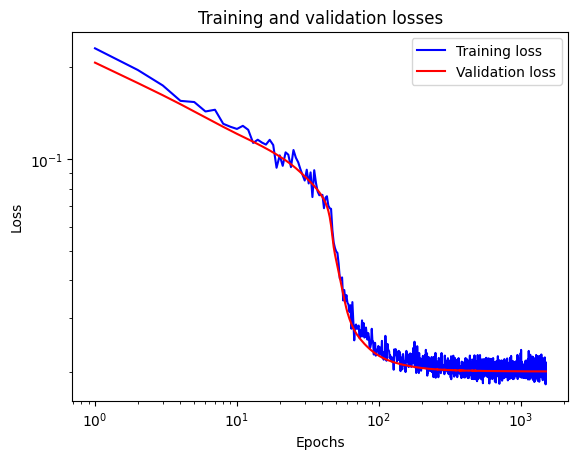

In [26]:
# Load the model with the smallest validation loss (if needed)
Controlled_quantile.load_state_dict(torch.load('MPC_controlled_quantile_TiDE_w10_larger_lr_less_epoch.pth'))

# Plot loss
loss = save_train_loss
val_loss = save_val_loss
epochs=range(1,len(loss)+1)
plt.figure()
plt.semilogy(epochs, loss,'b', label='Training loss')
plt.semilogy(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
#plt.savefig('lossLSTM32.png')
plt.show()

#### Result validation

forward time = 0.0013251304626464844


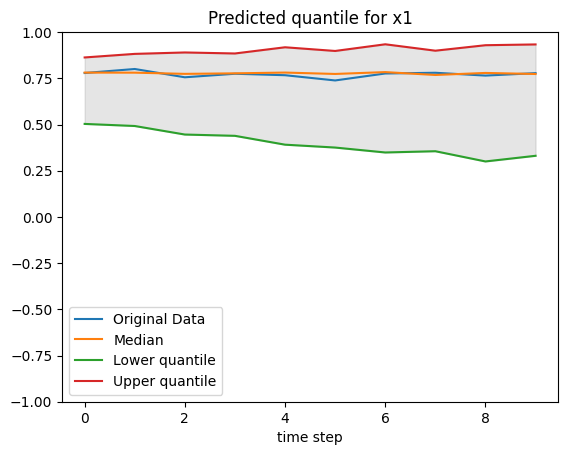

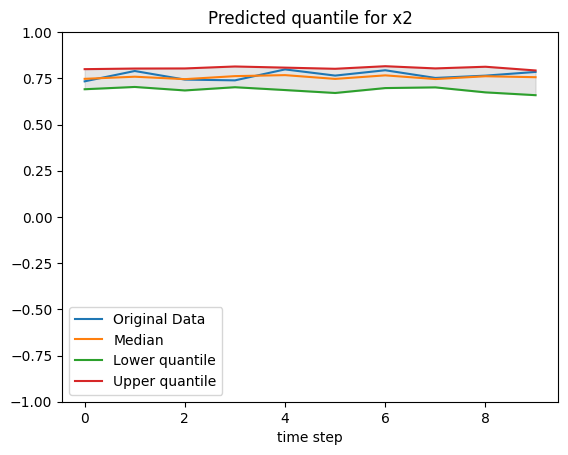

In [31]:
item = 6950 # Select the index for visualizing the results using validation data
#item = 800
#item = 6890

x_plot_past = Val_past[item,:,:].unsqueeze(0)
x_plot_future = Val_future_covariates[item,:,:].unsqueeze(0)
x_plot_val = [x_plot_past, x_plot_future, None]
y_plot_val = Val_target[item,:,:].unsqueeze(0)

Controlled_quantile.eval()

time1 = time.time()
y_hat = Controlled_quantile(x_plot_val)
time2 = time.time()
print(f"forward time = {time2-time1}")

# plot x1
plt.figure()
plt.plot(y_plot_val.to("cpu")[:,:,0].squeeze().numpy(),label="Original Data")
plt.plot(y_hat[:,:,0,1].squeeze().detach().to("cpu").numpy(),label="Median")
plt.plot(y_hat[:,:,0,0].squeeze().detach().to("cpu").numpy(),label="Lower quantile")
plt.plot(y_hat[:,:,0,2].squeeze().detach().to("cpu").numpy(),label="Upper quantile")
plt.title('Predicted quantile for x1')
plt.xlabel('time step')
plt.ylim(-1,1)
# plt.ylim([-10,5])

plt.fill_between(range(P),
                 y1=y_hat[:,:,0,0].squeeze().detach().to("cpu").numpy(),
                 y2=y_hat[:,:,0,2].squeeze().detach().to("cpu").numpy(),
                 alpha=0.2, color='gray')
plt.legend()

# plot x2
plt.figure()
plt.plot(y_plot_val.to("cpu")[:,:,1].squeeze().numpy(),label="Original Data")
plt.plot(y_hat[:,:,1,1].squeeze().detach().to("cpu").numpy(),label="Median")
plt.plot(y_hat[:,:,1,0].squeeze().detach().to("cpu").numpy(),label="Lower quantile")
plt.plot(y_hat[:,:,1,2].squeeze().detach().to("cpu").numpy(),label="Upper quantile")
plt.title('Predicted quantile for x2')
plt.xlabel('time step')
# plt.ylim([-5,2])

plt.fill_between(range(P),
                 y1=y_hat[:,:,1,0].squeeze().detach().to("cpu").numpy(),
                 y2=y_hat[:,:,1,2].squeeze().detach().to("cpu").numpy(),
                 alpha=0.2, color='gray')
plt.legend()
plt.ylim(-1,1)
plt.show()

## Traing tube using both x and e as predictors